# 3. Bias Correction Model

In [20]:
import geopandas as gpd
print(gpd.__version__)

ModuleNotFoundError: No module named 'geopandas'

In [19]:
import pandas as pd
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
import logging
import os

ModuleNotFoundError: No module named 'geopandas'

In [6]:
import os
print(os.getcwd())

/home/jovyan/BiasCorrectionCrowdsourcedData-cookbook/notebooks


In [10]:
print(truth_df.columns)

Index(['GRID_ID.1', 'STARTweek_stravaDATE_cast', 'GRID_ID',
       'ENDweek_stravaDATE_cast', 'SUM_total_trip_count', 'EcoCntr_weekly_SUM',
       'MAX_slopePct', 'STARTweek_Time', 'HEXid_weekID', 'HEXid_WeekID',
       ...
       'Spatial Component 28', 'Spatial Component 29', 'Spatial Component 30',
       'Spatial Component 31', 'Spatial Component 32', 'Spatial Component 33',
       'Spatial Component 34', 'Spatial Component 35', 'Spatial Component 36',
       'Spatial Component 37'],
      dtype='object', length=278)


In [13]:
print(truth_df.columns)

Index(['grid_id.1', 'startweek_stravadate_cast', 'grid_id',
       'endweek_stravadate_cast', 'sum_total_trip_count', 'ecocntr_weekly_sum',
       'max_slopepct', 'startweek_time', 'hexid_weekid', 'hexid_weekid',
       ...
       'spatial_component_28', 'spatial_component_29', 'spatial_component_30',
       'spatial_component_31', 'spatial_component_32', 'spatial_component_33',
       'spatial_component_34', 'spatial_component_35', 'spatial_component_36',
       'spatial_component_37'],
      dtype='object', length=278)


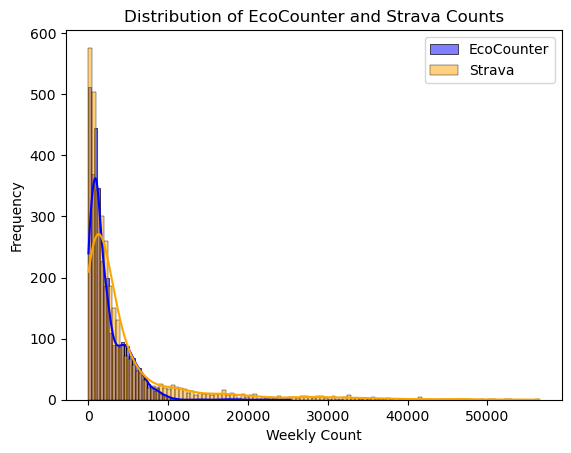

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of EcoCounter and Strava counts
sns.histplot(truth_df['EcoCntr_weekly_SUM'], kde=True, color='blue', label='EcoCounter')
sns.histplot(truth_df['SUM_total_trip_count'], kde=True, color='orange', label='Strava')
plt.legend()
plt.title('Distribution of EcoCounter and Strava Counts')
plt.xlabel('Weekly Count')
plt.ylabel('Frequency')
plt.show()

In [15]:
for col in truth_df.columns:
    print(f"'{col}'")

'GRID_ID.1'
'STARTweek_stravaDATE_cast'
'GRID_ID'
'ENDweek_stravaDATE_cast'
'SUM_total_trip_count'
'EcoCntr_weekly_SUM'
'MAX_slopePct'
'STARTweek_Time'
'HEXid_weekID'
'HEXid_WeekID'
'ENDweek_Time'
'week_id'
'week_start'
'_GRID_JOIN_'
'OBJECTID *'
'Shape *'
'SOURCE_ID'
'GRID_ID_cov'
'slopePct'
'TrailCounter'
'SqMeters'
'ASOSID'
'AR_asosID_hexID'
'Slope_10m_MEAN'
'OBJECTID'
'GRID_ID.1_cov'
'TIMESTEP_stravaDATE_cast'
'STARTTIME_stravaDATE_cast'
'ENDTIME_stravaDATE_cast'
'SUM_EcoCounter_WeeklyAggregation'
'SUM_total_trip_count_cov'
'SUM_ride_count'
'MAX_activity_type'
'MAX_slopePct_cov'
'SUM_forward_people_count'
'SUM_reverse_people_count'
'SUM_forward_commute_trip_count'
'SUM_reverse_commute_trip_count'
'SUM_forward_leisure_trip_count'
'SUM_reverse_leisure_trip_count'
'SUM_ebike_ride_count'
'SUM_forward_morning_trip_count'
'SUM_reverse_morning_trip_count'
'SUM_forward_midday_trip_count'
'SUM_reverse_midday_trip_count'
'SUM_forward_evening_trip_count'
'SUM_reverse_evening_trip_count'
'SUM_

### 3b. Covariate Selection & Model Setup

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define covariates and response
features = ['strava_count', 'trail_access', 'pop_density', 'median_income', 'age_18_34', 'bike_infra']
X = df[features]
y = df['eco_count']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation metrics
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R^2:", r2_score(y_test, y_pred))


### 3c. Correction Model Application

In [ ]:

# Apply bias correction to full dataset
df['eco_pred'] = model.predict(X)

# Plot predicted vs actual
sns.scatterplot(x='eco_count', y='eco_pred', data=df)
plt.plot([df['eco_count'].min(), df['eco_count'].max()],
         [df['eco_count'].min(), df['eco_count'].max()],
         '--', color='red')
plt.xlabel("Observed EcoCounter")
plt.ylabel("Predicted EcoCounter")
plt.title("Bias Corrected Predictions vs Observations")
plt.show()


### 3d. Spatial Validation Across Demographic Clusters

In [ ]:

# Load hex cluster and spatial data
hex_df = pd.read_csv('processed_data/hex_with_clusters.csv')

# Merge with predictions
merged = pd.merge(df, hex_df, on='hex_id')

# Calculate R² per cluster
cluster_scores = merged.groupby('cluster_label').apply(
    lambda g: r2_score(g['eco_count'], g['eco_pred'])
)

print(cluster_scores)

# Plot cluster scores
cluster_scores.plot(kind='bar', title='R² by Demographic Cluster')
plt.ylabel("R² Score")
plt.show()


### 3e. Time Series & Seasonal Comparison

In [ ]:

# Compare corrected vs original across time
weekly = df.groupby('week').agg({'eco_count': 'mean', 'eco_pred': 'mean', 'strava_count': 'mean'}).reset_index()

plt.figure(figsize=(12, 4))
plt.plot(weekly['week'], weekly['eco_count'], label='Observed EcoCounter')
plt.plot(weekly['week'], weekly['eco_pred'], label='Corrected Prediction')
plt.plot(weekly['week'], weekly['strava_count'], label='Raw Strava')
plt.legend()
plt.title("Weekly Trends: Observed vs Corrected vs Raw Strava")
plt.xlabel("Week")
plt.ylabel("Mean Weekly Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
